In [1]:
from zonal_stats_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# disable window width for better printing of numpy arrays
np.set_printoptions(linewidth=np.inf)

In [2]:
# set parameters for the simulation

# grid cell sizes (m) & corresponding names
grid_names = ["1km", "2km", "4km", "10km"]
grid_sizes = [1000, 2000, 4000, 10000]

# scale factors for each grid size
scale_factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# get demo polygons dict (all HUC10 or HUC12 polygons within a bounding box defined by a HUC8)
huc8_id = "19080404"
polygons, bbox = get_huc10_and_huc12_polygons_within_huc8(huc8_id)

Found 353 polygons within the HUC8 19080404 bounding box.
Mean area of 63 HUC10 polygons: 660.17 km²
Mean area of 289 HUC12 polygons: 108.65 km²


In [3]:
experiment_data = []

for grid_name, grid_size in zip(grid_names, grid_sizes):
    data_dict = {grid_name: {}}

    # create random dataset
    ds = populate_dataset(create_empty_dataset(grid_size, bbox))
    data_dict[grid_name]["original_dataset"] = ds
    data_dict[grid_name]["grid_size_km"] = grid_size / 1000

    # for each scale factor, interpolate the dataset, rasterize the polygons, and calculate zonal stats
    for scale_factor in scale_factors:
        data_dict[grid_name][scale_factor] = {}
        interp_ds = interpolate_dataset(ds, "x", "y", scale_factor, "nearest")
        data_dict[grid_name][scale_factor]["interpolated_dataset"] = interp_ds

        data_dict[grid_name][scale_factor]["rasterized_polygons"] = {}
        for key in polygons.keys():

            poly_id = key
            poly_area_km2 = polygons[key]["area_km2"]
            poly_type = polygons[key]["area_type"]
            poly_array = rasterize_polygon(interp_ds, "x", "y", polygons[key]["gdf"])

            zonal_stats = calculate_zonal_stats(interp_ds, poly_array)

            data_dict[grid_name][scale_factor]["rasterized_polygons"][poly_id] = {
                "array": poly_array,
                "area_km2": poly_area_km2,
                "area_type": poly_type,
                "zonal_stats": zonal_stats,
            }

    experiment_data.append(data_dict)

In [4]:
# sanity check - do all the shapes make sense?
# do means and counts in zonal stats vary as expected?

for grid in experiment_data:
    print(list(grid.keys())[0])
    print(
        "Original dataset shape:",
        grid[list(grid.keys())[0]]["original_dataset"].data.shape,
    )
    print("Interpolated dataset shapes:")
    for scale_factor in scale_factors:
        print(
            "     ",
            scale_factor,
            grid[list(grid.keys())[0]][scale_factor]["interpolated_dataset"].data.shape,
        )

        print("         Rasterized polygon shapes:")
        for key in polygons.keys():
            print(
                "                 ",
                key,
                grid[list(grid.keys())[0]][scale_factor]["rasterized_polygons"][key][
                    "array"
                ].shape,
                " ---- ",
                grid[list(grid.keys())[0]][scale_factor]["rasterized_polygons"][key][
                    "zonal_stats"
                ],
            )

1km
Original dataset shape: (222, 298)
Interpolated dataset shapes:
      1 (222, 298)
         Rasterized polygon shapes:
                  19080404 (222, 298)  ----  {'mean': 0.02661344130454583, 'count': 10433}
                  1909020401 (222, 298)  ----  {'mean': -0.08815564519553976, 'count': 547}
                  1908040418 (222, 298)  ----  {'mean': -0.3379178988620442, 'count': 320}
                  1908040321 (222, 298)  ----  {'mean': 0.043937324054562604, 'count': 518}
                  1909010401 (222, 298)  ----  {'mean': -0.06348196362602496, 'count': 981}
                  1908040320 (222, 298)  ----  {'mean': 0.1781328885651471, 'count': 901}
                  1909010409 (222, 298)  ----  {'mean': -0.1172223676047342, 'count': 609}
                  1908040416 (222, 298)  ----  {'mean': 0.013152916133118293, 'count': 246}
                  1908040414 (222, 298)  ----  {'mean': 0.10250488495398473, 'count': 293}
                  1908040409 (222, 298)  ----  {'mean':

In [5]:
# create a pandas dataframe to summarize the experiment data
# the columns: grid_name, scale_factor, poly_id, poly_area_km2, poly_area_type, mean, count
# the rows: each polygon in each grid at each scale factor
summary = []
for grid in experiment_data:
    grid_name = list(grid.keys())[0]
    for scale_factor in scale_factors:
        for key in polygons.keys():
            poly_id = key
            poly_area_km2 = grid[grid_name][scale_factor]["rasterized_polygons"][
                poly_id
            ]["area_km2"]
            zonal_stats = grid[grid_name][scale_factor]["rasterized_polygons"][poly_id][
                "zonal_stats"
            ]
            poly_area_type = grid[grid_name][scale_factor]["rasterized_polygons"][
                poly_id
            ]["area_type"]
            summary.append(
                [
                    grid_name,
                    scale_factor,
                    poly_id,
                    poly_area_km2,
                    poly_area_type,
                    zonal_stats["mean"],
                    zonal_stats["count"],
                ]
            )

summary_df = pd.DataFrame(
    summary,
    columns=[
        "grid_name",
        "scale_factor",
        "poly_id",
        "poly_area_km2",
        "poly_area_type",
        "mean",
        "count",
    ],
)
print(summary_df)

      grid_name  scale_factor       poly_id  poly_area_km2 poly_area_type  \
0           1km             1      19080404   10440.947005           HUC8   
1           1km             1    1909020401     548.094655          HUC10   
2           1km             1    1908040418     321.261478          HUC10   
3           1km             1    1908040321     517.962018          HUC10   
4           1km             1    1909010401     981.867334          HUC10   
...         ...           ...           ...            ...            ...   
16939      10km            12  190803090101      59.917887          HUC12   
16940      10km            12  190902010105     131.880741          HUC12   
16941      10km            12  190804031305     877.416664          HUC12   
16942      10km            12  190902010204      36.923924          HUC12   
16943      10km            12  190902010504     133.510321          HUC12   

           mean  count  
0      0.026613  10433  
1     -0.088156    547  


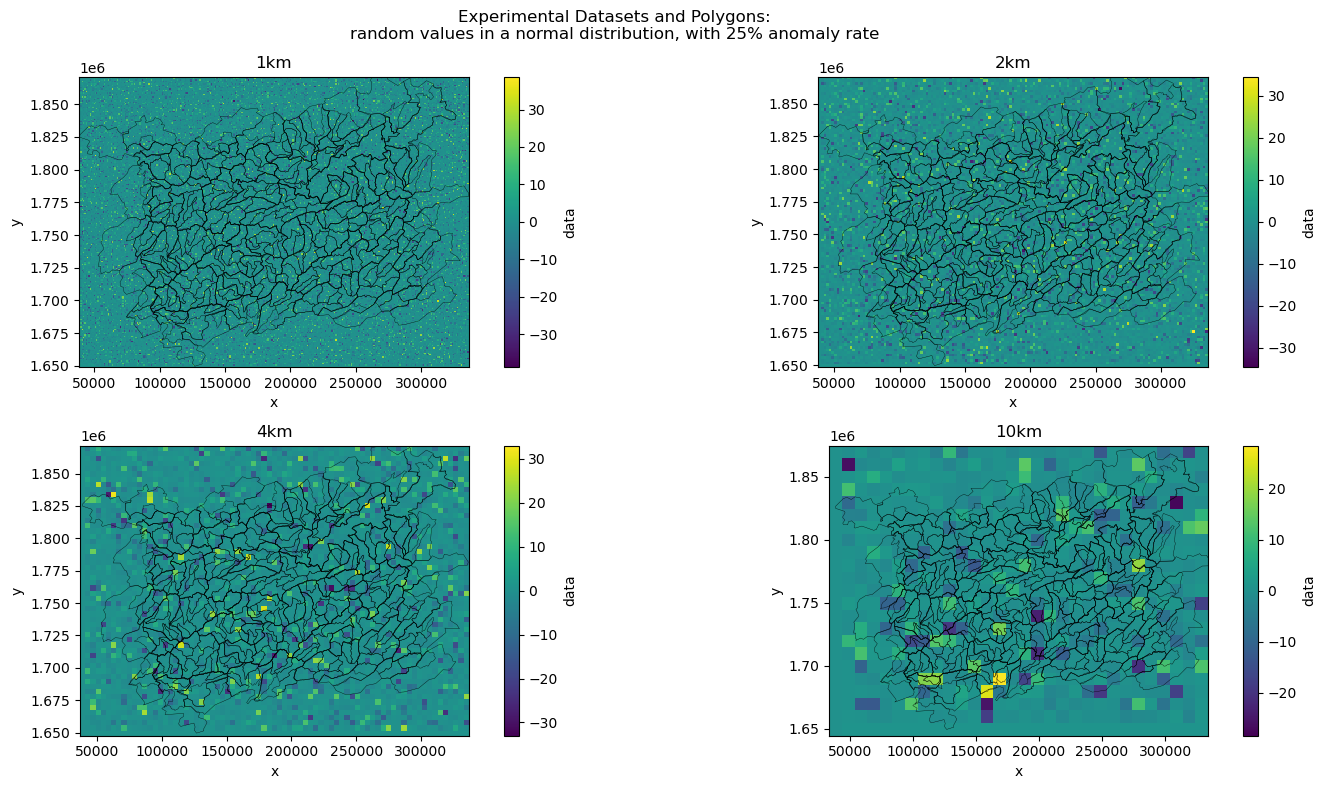

In [6]:
# plot a 4 panel with the original datasets and the polygons

# first merge the original polygon geodataframes into a single geodataframe
gdfs = [polygons[key]["gdf"] for key in polygons.keys()]
merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for i, grid in enumerate(experiment_data):
    grid_name = list(grid.keys())[0]
    ds = grid[grid_name]["original_dataset"]
    ax = axs[i // 2, i % 2]
    ds.data.plot(ax=ax, cmap="viridis")
    ax.set_title(grid_name)
    merged_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.25)

fig.suptitle(
    "Experimental Datasets and Polygons:\nrandom values in a normal distribution, with 25% anomaly rate"
)
plt.tight_layout()

(1790583.5561738778, 1808152.775278993)

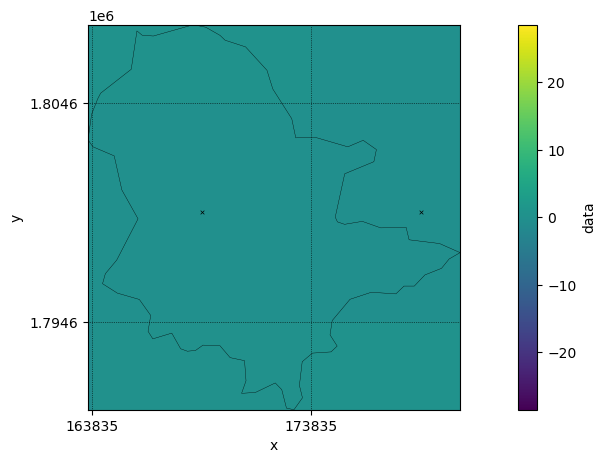

In [7]:
# plot a single HUC12 polygon with the 10km grid and original dataset
fig, ax = plt.subplots(figsize=(15, 5))
poly_id = "190804040205"
poly_gdf_huc12 = polygons[poly_id]["gdf"]
ds = experiment_data[3]["10km"]["original_dataset"]
ds.data.plot(ax=ax, cmap="viridis")
poly_gdf_huc12.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.25)

# add gridlines for the 10km grid
x = np.arange(ds.data.x.min() + 5000, ds.data.x.max(), 10000)
y = np.arange(ds.data.y.min() + 5000, ds.data.y.max(), 10000)
ax.set_xticks(x)
ax.set_yticks(y)
ax.grid(which="both", color="black", linestyle=":", linewidth=0.5)

# add X marks at the center of the grid cells
x_centers = x[:-1] + 5000
y_centers = y[:-1] + 5000
for xc in x_centers:
    for yc in y_centers:
        ax.scatter(xc, yc, color="black", marker="x", s=7, linewidth=0.5)

# set plot xlim and ylim based on polygon bounds
ax.set_xlim(poly_gdf_huc12.bounds.minx.min(), poly_gdf_huc12.bounds.maxx.max())
ax.set_ylim(poly_gdf_huc12.bounds.miny.min(), poly_gdf_huc12.bounds.maxy.max())

(1790583.5561738778, 1808152.775278993)

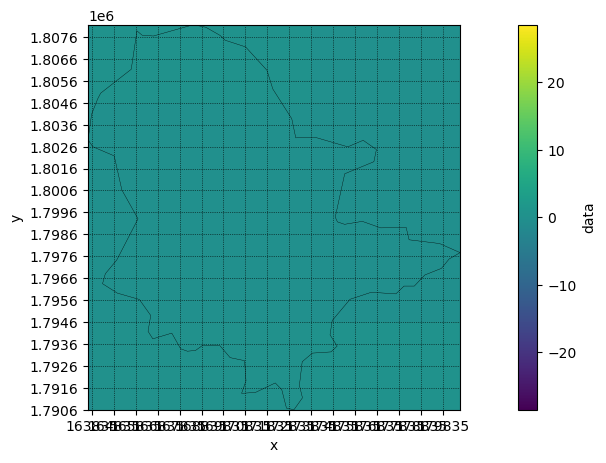

In [8]:
# plot a single HUC12 polygon with the 10km grid and original dataset
fig, ax = plt.subplots(figsize=(15, 5))
poly_id = "190804040205"
poly_gdf_huc12 = polygons[poly_id]["gdf"]
ds = experiment_data[3]["10km"]["original_dataset"]
ds.data.plot(ax=ax, cmap="viridis")
poly_gdf_huc12.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.25)

# add gridlines for the 10km grid
x = np.arange(ds.data.x.min(), ds.data.x.max(), 1000)
y = np.arange(ds.data.y.min(), ds.data.y.max(), 1000)
ax.set_xticks(x)
ax.set_yticks(y)
ax.grid(which="both", color="black", linestyle=":", linewidth=0.5)

# set plot xlim and ylim based on polygon bounds
ax.set_xlim(poly_gdf_huc12.bounds.minx.min(), poly_gdf_huc12.bounds.maxx.max())
ax.set_ylim(poly_gdf_huc12.bounds.miny.min(), poly_gdf_huc12.bounds.maxy.max())

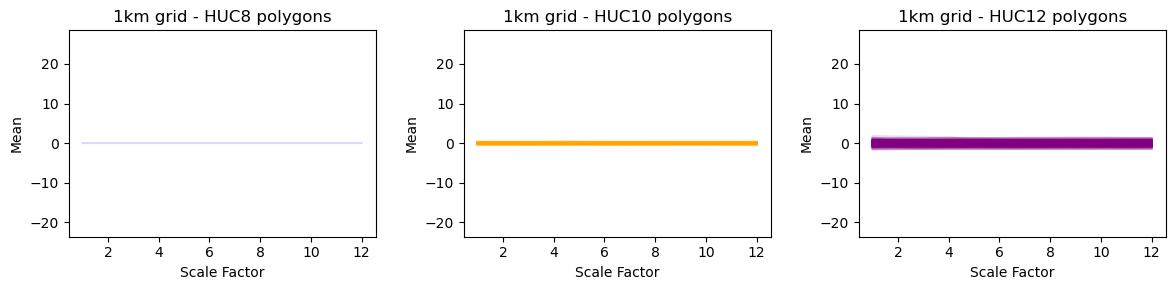

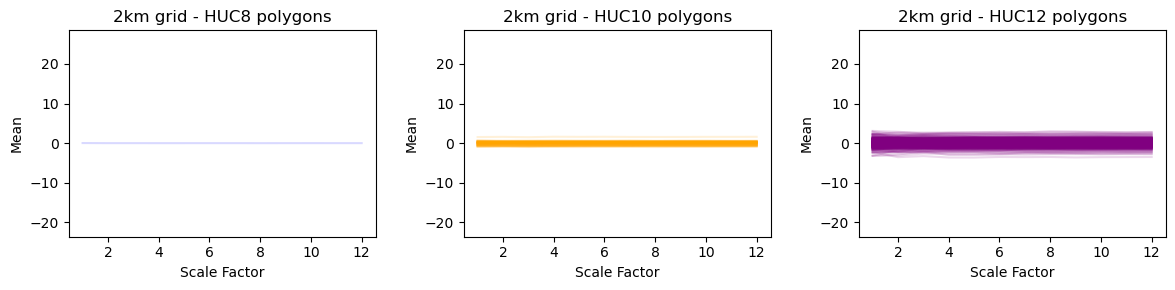

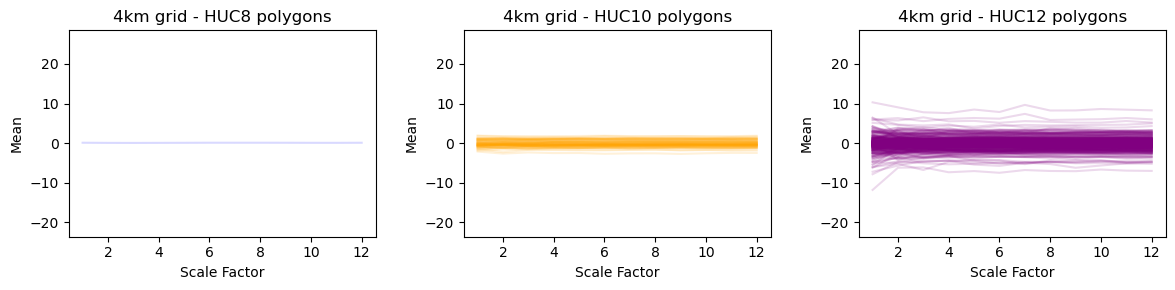

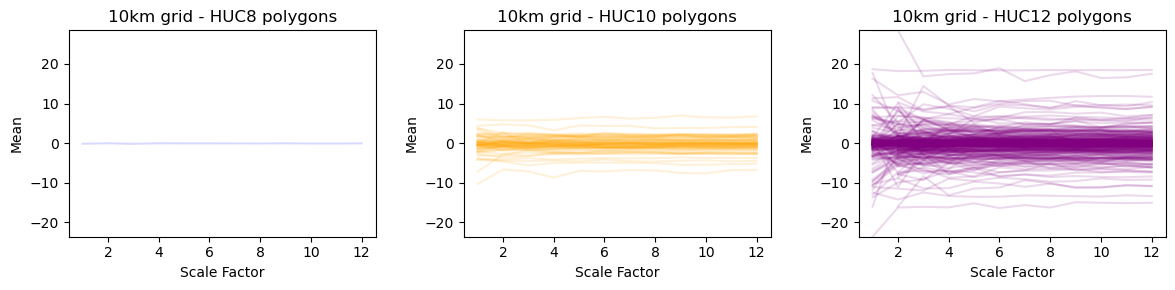

In [9]:
# for each grid_name, plot the mean for each polygon at each scale factor

color_dict = {"HUC8": "blue", "HUC10": "orange", "HUC12": "purple"}
for grid_name in grid_names:
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    common_yaxis_min = summary_df["mean"].min()
    common_yaxis_max = summary_df["mean"].max()

    for ax, area_type in zip(axs.flat, ["HUC8", "HUC10", "HUC12"]):
        # only use polygons if they are of the area_type
        area_type_polygons = {}
        for id, poly in polygons.items():
            if poly["area_type"] == area_type:
                area_type_polygons[id] = poly

        for polygon in area_type_polygons.keys():
            poly_id = polygon
            poly_data = summary_df[
                (summary_df["grid_name"] == grid_name)
                & (summary_df["poly_id"] == poly_id)
            ]
            # plot the data, choosing color based on the color dict
            ax.plot(
                poly_data["scale_factor"],
                poly_data["mean"],
                # label=poly_id + " (" + poly_data["poly_area_type"].iloc[0] + ")",
                color=color_dict[poly_data["poly_area_type"].iloc[0]],
                alpha=0.15,
            )

            ax.set_ylim([common_yaxis_min, common_yaxis_max])
            ax.set_title(grid_name + " grid - " + area_type + " polygons")
            ax.set_xlabel("Scale Factor")
            ax.set_ylabel("Mean")

    plt.tight_layout()
    plt.show()

In [10]:
# we will add a column for the grid cell area in km2
summary_df["grid_cell_area_km2"] = None
summary_df.loc[summary_df["grid_name"] == "1km", "grid_cell_area_km2"] = 1
summary_df.loc[summary_df["grid_name"] == "2km", "grid_cell_area_km2"] = 4
summary_df.loc[summary_df["grid_name"] == "4km", "grid_cell_area_km2"] = 16
summary_df.loc[summary_df["grid_name"] == "10km", "grid_cell_area_km2"] = 100

summary_df

grid_name  scale_factor       poly_id  poly_area_km2 poly_area_type  \
0           1km             1      19080404   10440.947005           HUC8   
1           1km             1    1909020401     548.094655          HUC10   
2           1km             1    1908040418     321.261478          HUC10   
3           1km             1    1908040321     517.962018          HUC10   
4           1km             1    1909010401     981.867334          HUC10   
...         ...           ...           ...            ...            ...   
16939      10km            12  190803090101      59.917887          HUC12   
16940      10km            12  190902010105     131.880741          HUC12   
16941      10km            12  190804031305     877.416664          HUC12   
16942      10km            12  190902010204      36.923924          HUC12   
16943      10km            12  190902010504     133.510321          HUC12   

           mean  count grid_cell_area_km2  
0      0.026613  10433                  1  
1     -0.088156    547                  1  
2     -0.337918    320                  1  
3      0.043937    518                  1  
4     -0.063482    981                  1  
...         ...    ...                ...  
16939 -6.265804     91                100  
16940 -5.361719    204                100  
16941 -1.376829   1357                100  
16942  0.551459     54                100  
16943 -1.938519    207                100  

[16944 rows x 8 columns]

In [11]:
import random

# let's pick 40 random polygons (plus the sole HUC8 polygon) so we can visually determine the best scale factor for the grid cell area
# and manually add the optimal scale factor to the summary table

# get 15 random HUC10 polygons and 15 random HUC12 polygons from the master list
# get the HUC8 polygon as well
huc10_keys = [key for key in polygons.keys() if polygons[key]["area_type"] == "HUC10"]
huc12_keys = [key for key in polygons.keys() if polygons[key]["area_type"] == "HUC12"]
random_huc10_keys = random.sample(huc10_keys, 15)
random_huc12_keys = random.sample(huc12_keys, 15)
random_poly_keys = random_huc10_keys + random_huc12_keys + [huc8_id]

random_poly_keys

['1908030903',
 '1908040206',
 '1909020105',
 '1908040401',
 '1908040321',
 '1908040325',
 '1908040314',
 '1908040315',
 '1908040403',
 '1908040417',
 '1908040205',
 '1908040322',
 '1908040410',
 '1908040312',
 '1908031116',
 '190804040405',
 '190902010202',
 '190804040802',
 '190804040605',
 '190804040506',
 '190804041105',
 '190803090306',
 '190803090207',
 '190804041501',
 '190804031503',
 '190804020507',
 '190804040205',
 '190803110502',
 '190804041502',
 '190803111806',
 '19080404']

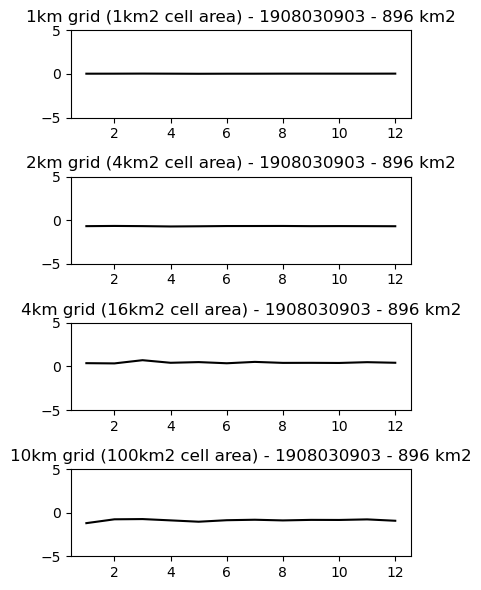

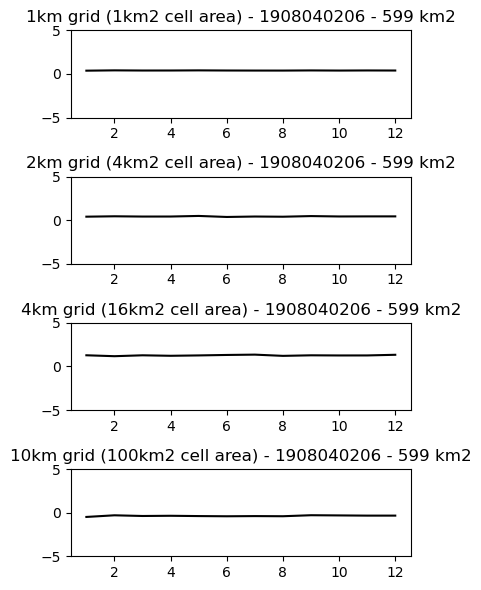

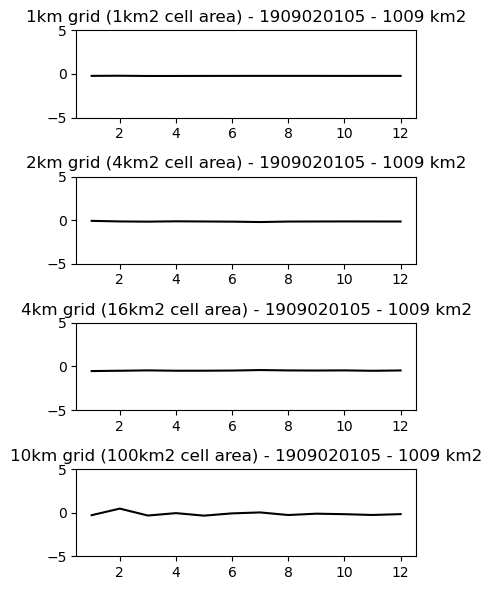

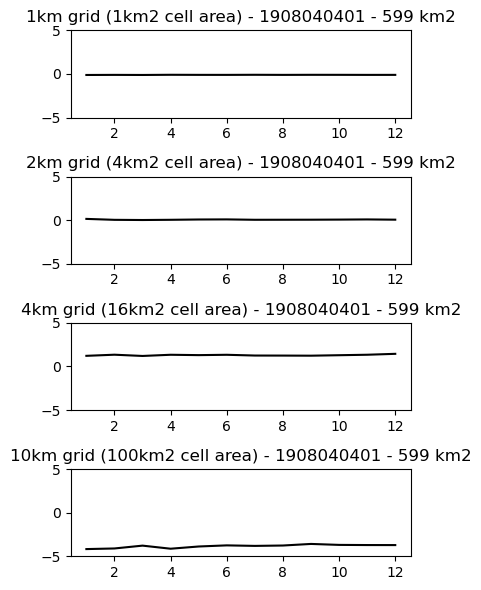

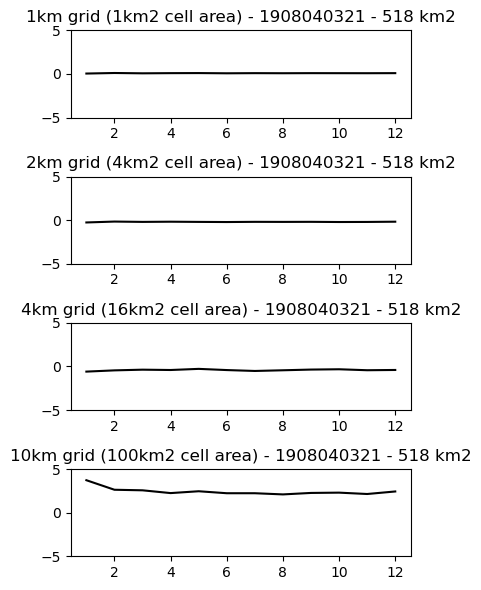

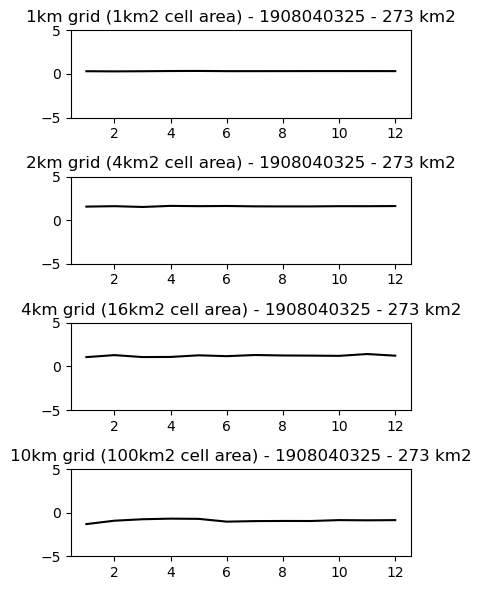

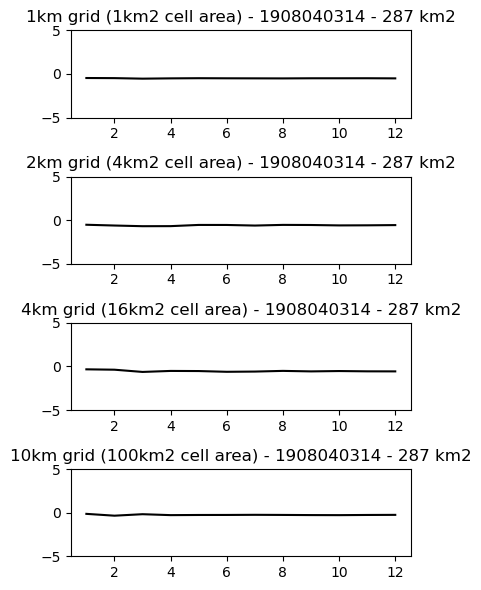

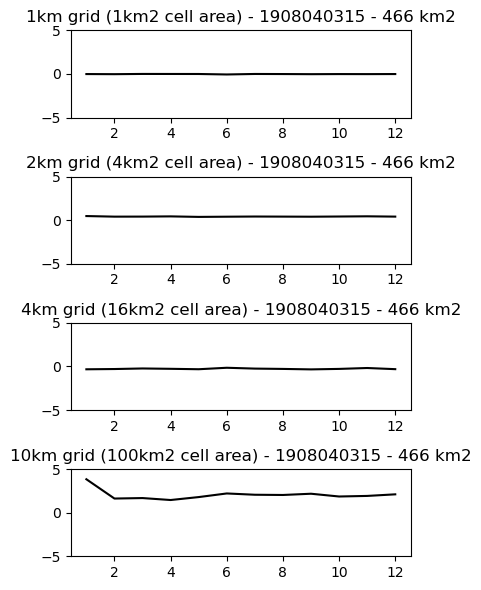

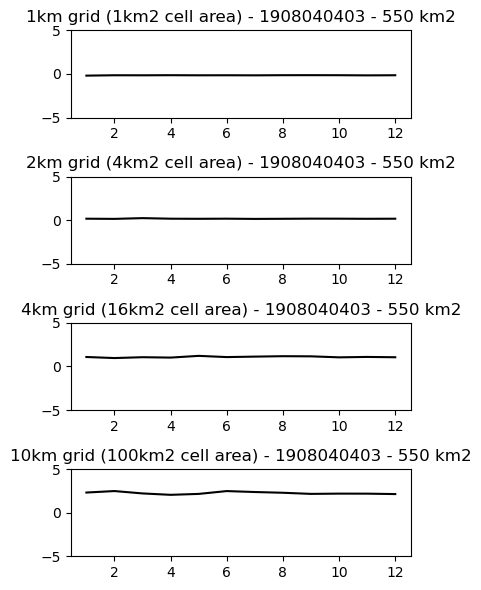

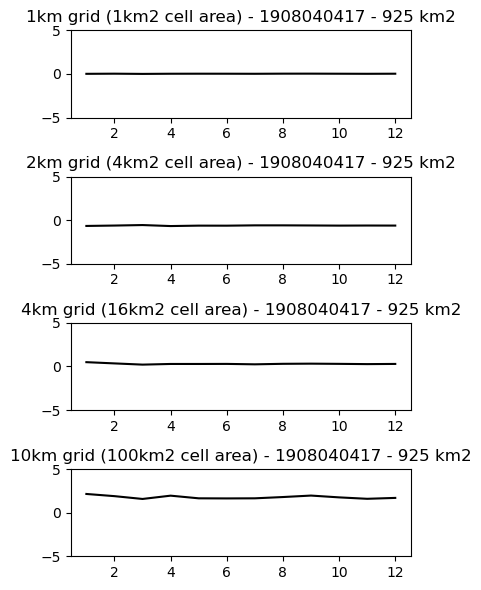

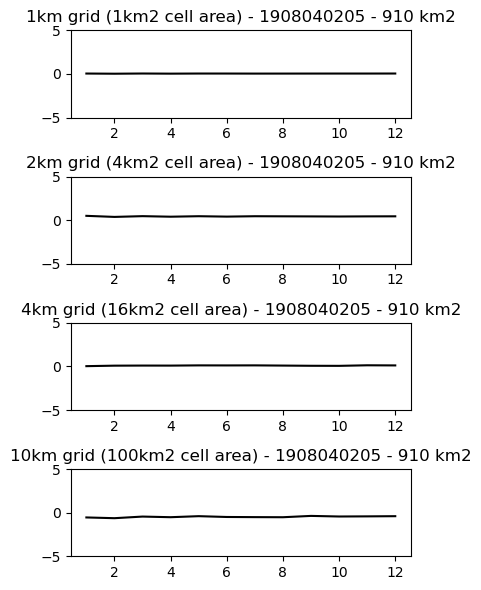

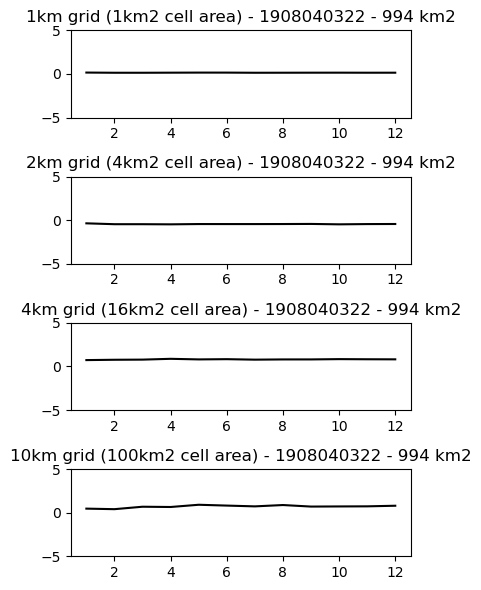

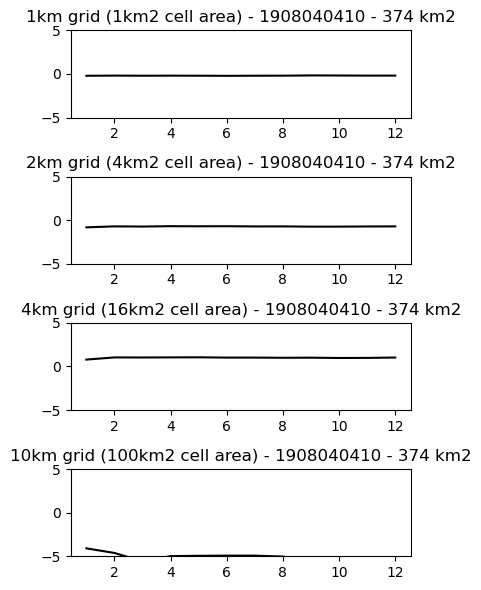

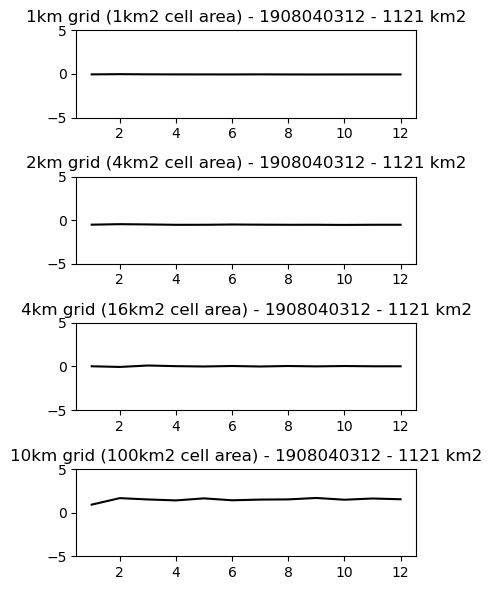

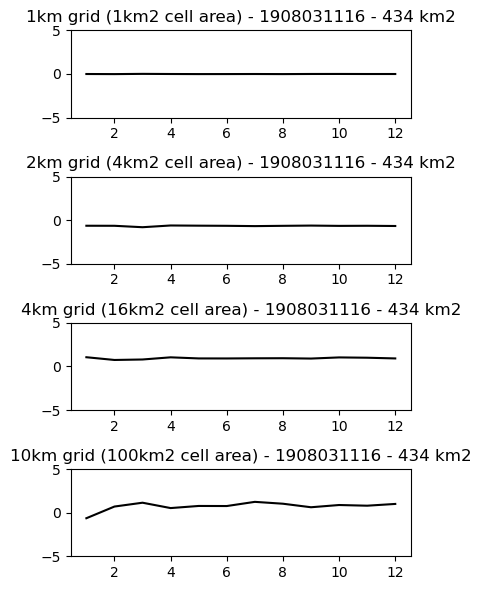

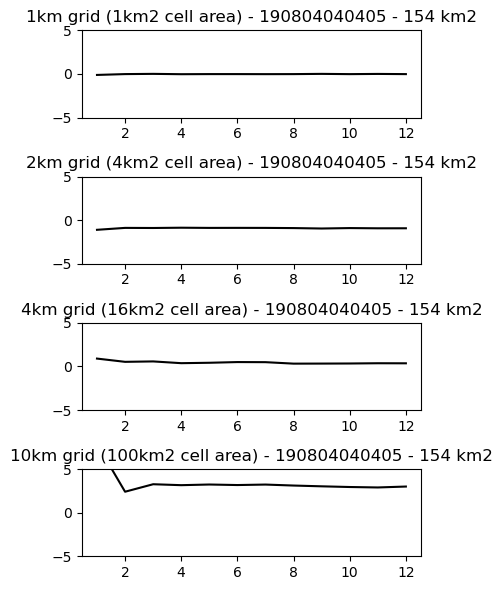

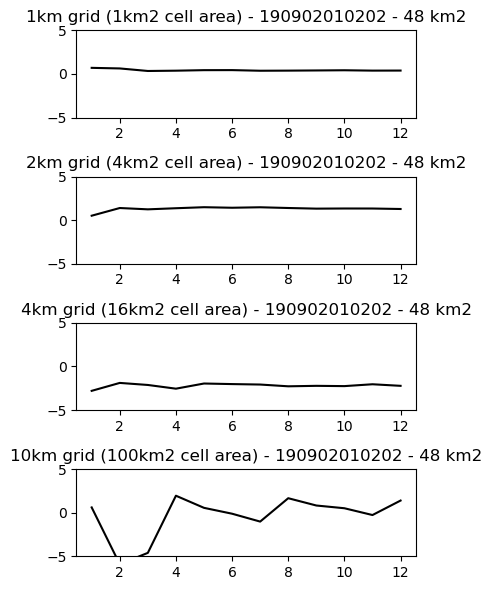

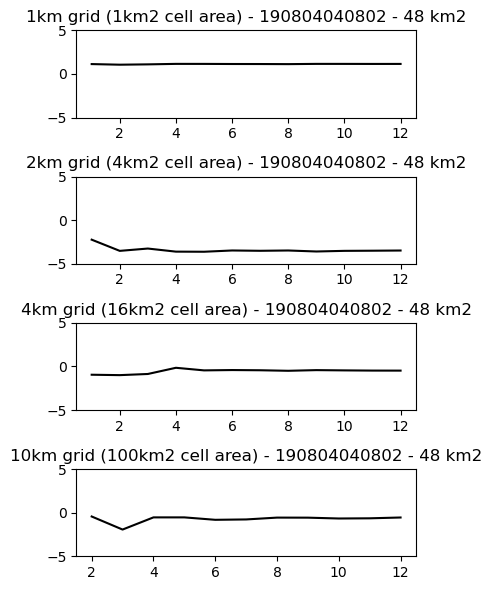

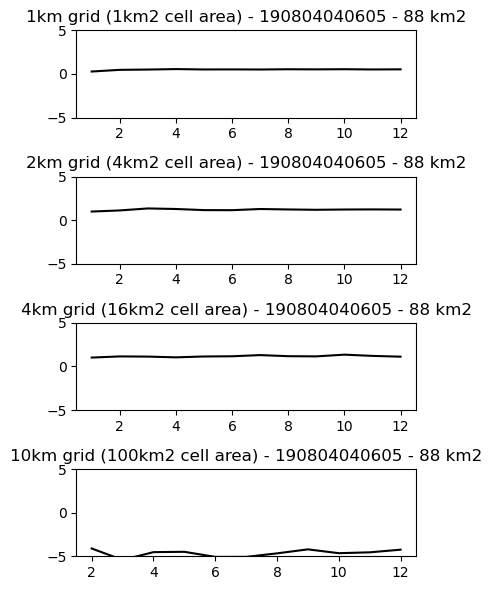

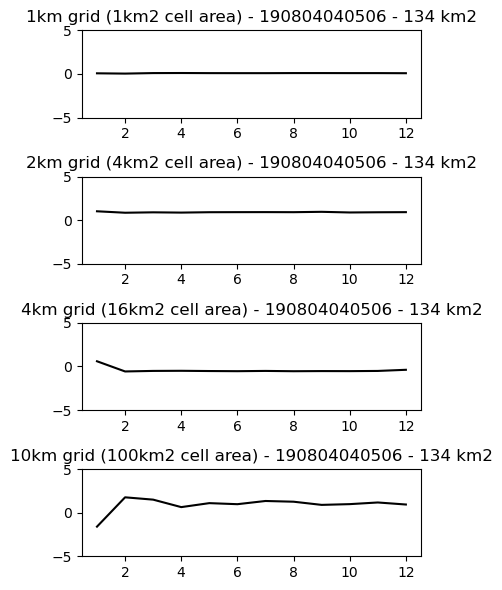

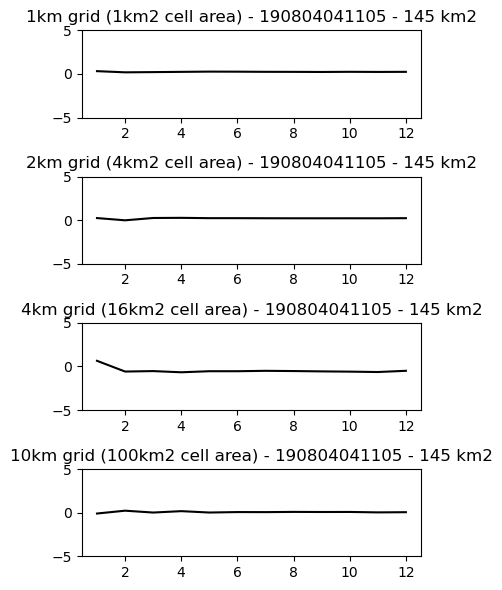

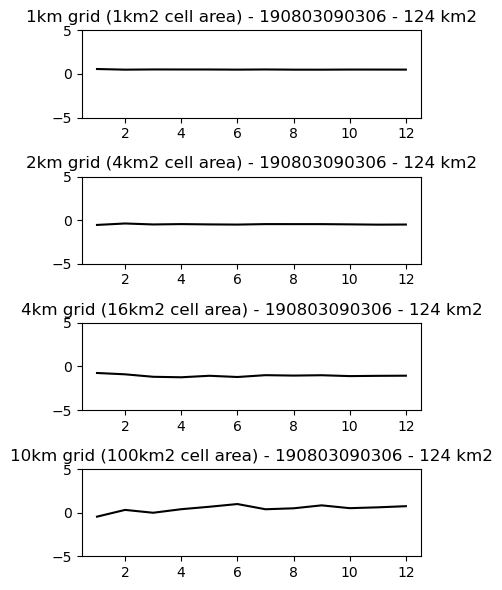

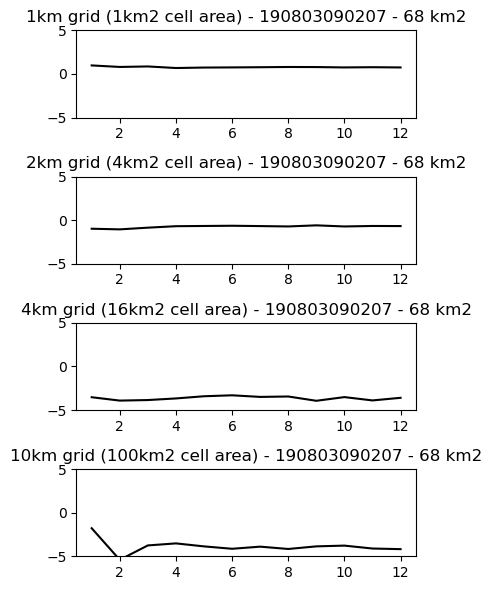

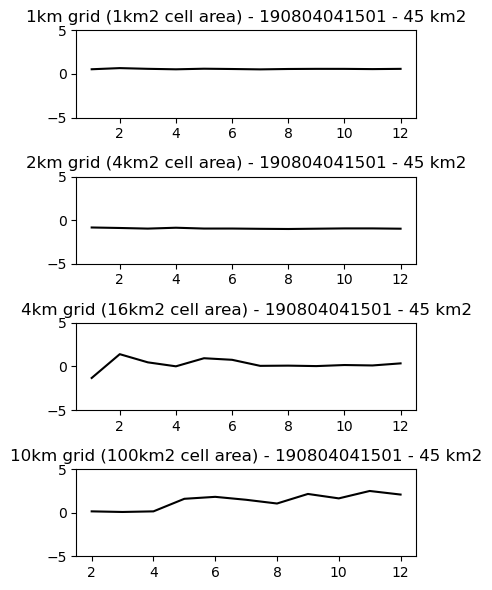

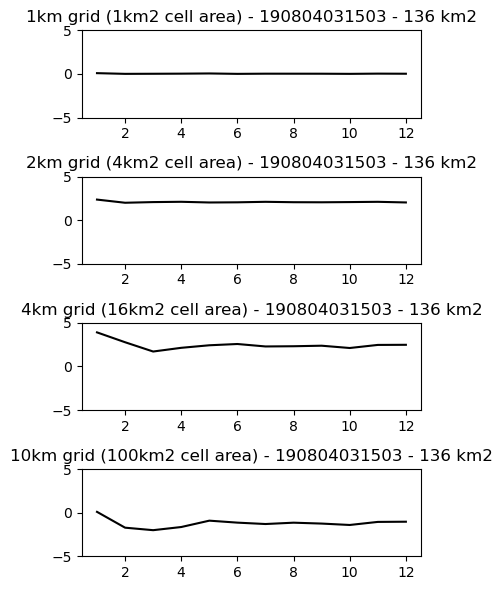

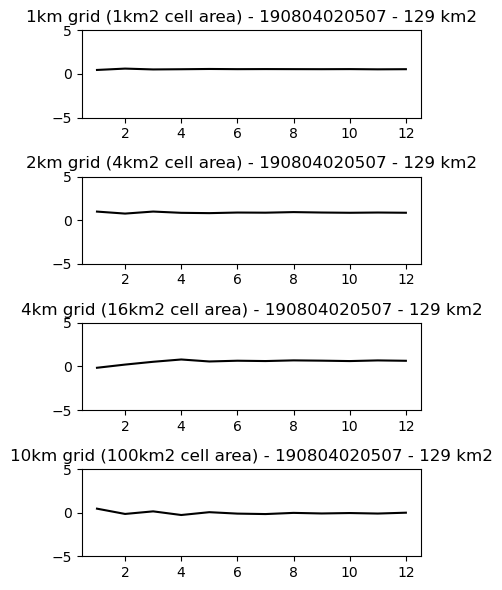

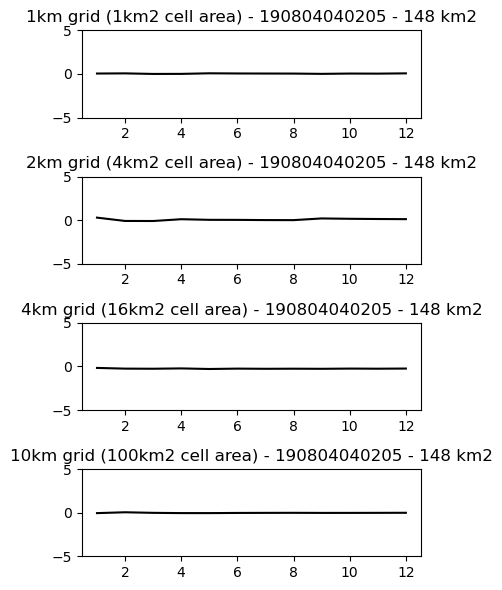

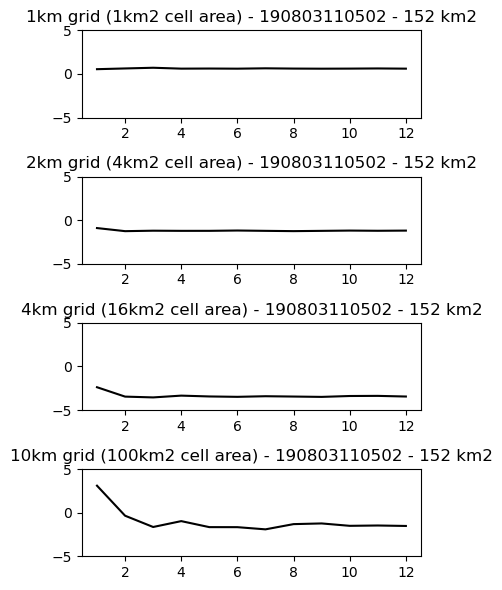

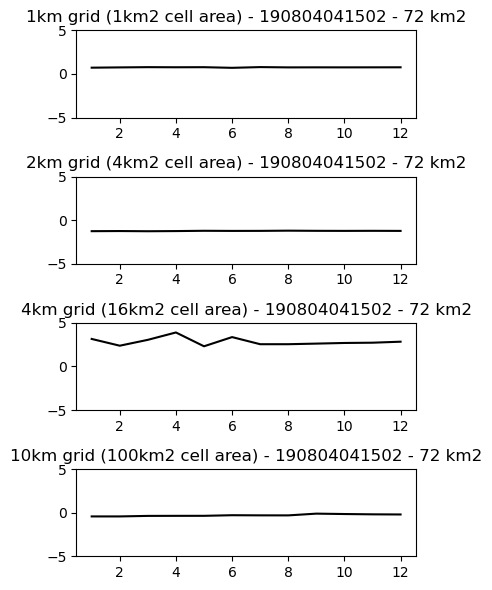

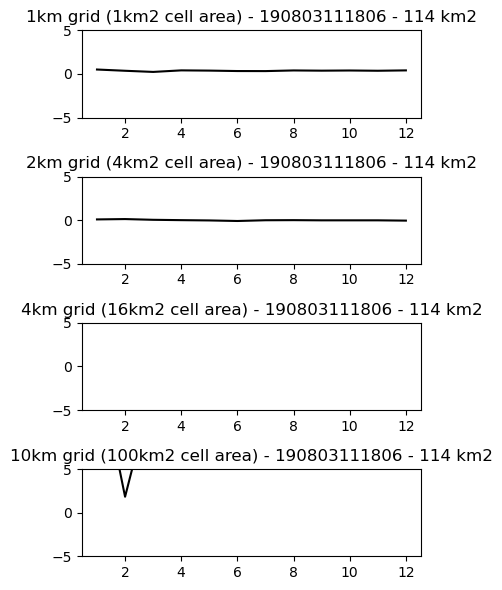

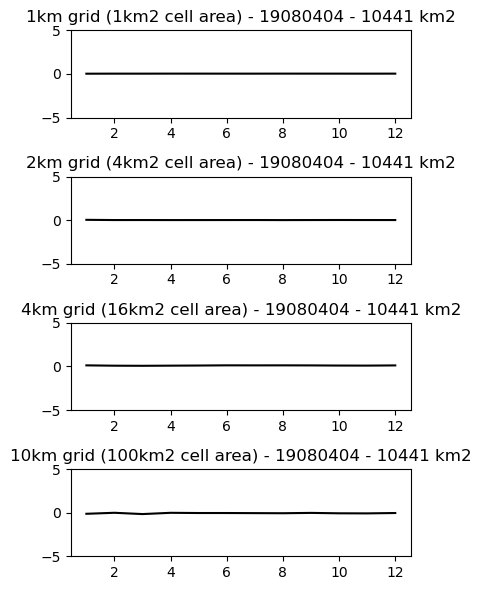

In [12]:
# for each of the random polygons, plot a 4 panel (one for each grid) showing means on the y axis and scale factors on the x axis

for poly_id in random_poly_keys:
    fig, axs = plt.subplots(4, 1, figsize=(4, 6))
    for ax, grid_name in zip(axs.flat, grid_names):
        poly_data = summary_df[
            (summary_df["grid_name"] == grid_name) & (summary_df["poly_id"] == poly_id)
        ]

        grid_cell_area = poly_data["grid_cell_area_km2"].iloc[0]
        poly_area = poly_data["poly_area_km2"].iloc[0]

        ax.plot(poly_data["scale_factor"], poly_data["mean"], color="black")

        ax.set_title(
            grid_name
            + " grid ("
            + str(grid_cell_area)
            + "km2 cell area) - "
            + poly_id
            + " - "
            + str(round(poly_area))
            + " km2"
        )
        # ax.set_xlabel("Scale Factor")
        # ax.set_ylabel("Mean")
        ax.set_ylim([-5, 5])

    plt.tight_layout()
    plt.show()

In [18]:
# import the data gleaned from the visual inspection of the plots
model_df = pd.read_csv("zonal_stats_data.csv")

# add a row with a very large area to constrain the model
new_row = pd.DataFrame.from_dict(
    {
        "grid_cell_area_km2": 100,
        "polygon_area_km2": 10000000,
        "optimal_scale_factor": 1,
    },
    orient="index",
).T

model_df = pd.concat([model_df, new_row], ignore_index=True)

# calculate the ratio of the polygon area to grid cell area
model_df["ratio"] = model_df["polygon_area_km2"] / model_df["grid_cell_area_km2"]

model_df

grid_cell_area_km2  polygon_area_km2  optimal_scale_factor        ratio
0                     1               896                     1     896.0000
1                     4               896                     1     224.0000
2                    16               896                     4      56.0000
3                   100               896                     6       8.9600
4                     1               599                     1     599.0000
..                  ...               ...                   ...          ...
120                   1             10441                     1   10441.0000
121                   4             10441                     1    2610.2500
122                  16             10441                     1     652.5625
123                 100             10441                     2     104.4100
124                 100          10000000                     1  100000.0000

[125 rows x 4 columns]

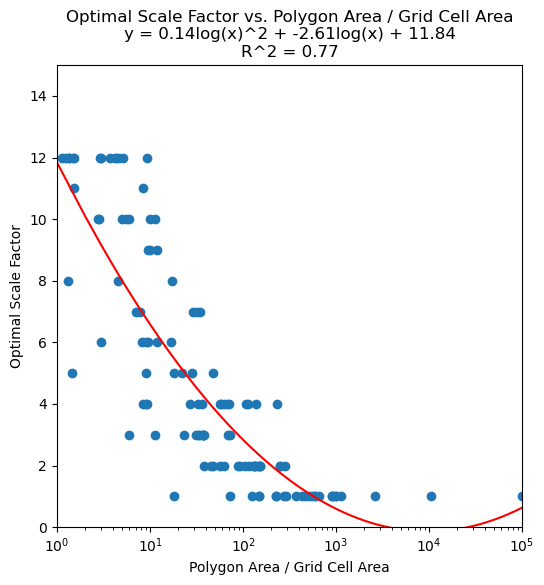

In [19]:
# create a scatterplot showing the relationship between the ratio and the optimal scale factor
# use a log scale for the x axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_df["ratio"], model_df["optimal_scale_factor"])
ax.set_xscale("log")
ax.set_xlabel("Polygon Area / Grid Cell Area")
ax.set_ylabel("Optimal Scale Factor")


# add a least square polynomial line of best fit
poly = np.polyfit(np.log(model_df["ratio"]), model_df["optimal_scale_factor"], 2)
x = np.linspace(0.01, 100000, 100000)
y = np.polyval(poly, np.log(x))
ax.plot(x, y, color="red")

# # get the R^2 value
r_squared = (
    np.corrcoef(
        model_df["optimal_scale_factor"], np.polyval(poly, np.log(model_df["ratio"]))
    )[0, 1]
    ** 2
)

# # print the function of the line in the plot
function_string = str(
    "y = "
    + str(round(poly[0], 2))
    + "log(x)^2 + "
    + str(round(poly[1], 2))
    + "log(x) + "
    + str(round(poly[2], 2))
)
ax.set_title(
    "Optimal Scale Factor vs. Polygon Area / Grid Cell Area\n"
    + function_string
    + "\nR^2 = "
    + str(round(r_squared, 2))
)

ax.set_xlim([1, 100000])
ax.set_ylim([0, 15])


plt.show()

Text(0.5, 1.0, 'Optimal Scale Factor vs. Polygon Area / Grid Cell Area\ny = (0x + 350) / (x + 24) + 1')

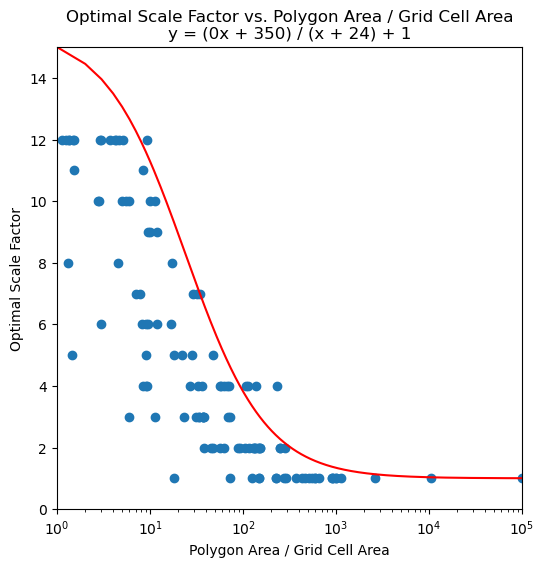

In [21]:
# plot both the original function and the new function together
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_df["ratio"], model_df["optimal_scale_factor"])
ax.set_xscale("log")
ax.set_xlabel("Polygon Area / Grid Cell Area")
ax.set_ylabel("Optimal Scale Factor")


# fit a hyperbolic function with vertical asymptote horizontal asymptote at 1
def hyp_function(x, m, b, c, h):
    y = (m * x + b) / (x - c) + h
    return y


m = 0
b = 350
c = -24
h = 1

x = np.linspace(0.01, 1000000, 1000000)
y = hyp_function(x, m, b, c, h)
ax.plot(x, y, color="red")


ax.set_xlim([1, 100000])
ax.set_ylim([0, 15])


# # print the function of the line in the plot
function_string = str(
    "y = (" + str(m) + "x + " + str(b) + ") / (x + " + str(abs(c)) + ") + " + str(h)
)
ax.set_title(
    "Optimal Scale Factor vs. Polygon Area / Grid Cell Area\n" + function_string
)

In [22]:
# interpolate the original datasets to each scale factor
# and time the function to see how long it takes

import time

# create a list to store the times
times = []

for grid in experiment_data:
    grid_name = list(grid.keys())[0]
    ds = grid[grid_name]["original_dataset"]
    for scale_factor in np.arange(1, 16):
        start_time = time.time()
        interp_ds = interpolate_dataset(ds, "x", "y", scale_factor, "nearest")
        end_time = time.time()
        # substract end from start and convert to milliseconds
        ms = (end_time - start_time) * 1000
        times.append([grid_name, scale_factor, ms])

Text(0.5, 1.0, 'Resampling Time by Scale Factor')

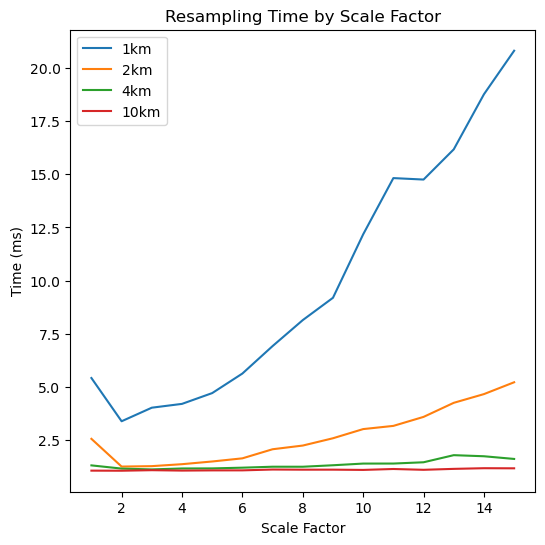

In [23]:
# plot the times
times_df = pd.DataFrame(times, columns=["grid_name", "scale_factor", "ms"])
fig, ax = plt.subplots(figsize=(6, 6))
for grid_name in grid_names:
    data = times_df[times_df["grid_name"] == grid_name]
    ax.plot(data["scale_factor"], data["ms"], label=grid_name)

ax.legend()
ax.set_xlabel("Scale Factor")
ax.set_ylabel("Time (ms)")

plt.title("Resampling Time by Scale Factor")